In [12]:
import os
import json
import torch
import numpy as np
import cv2
import sklearn
from matplotlib import pyplot as plt, patches

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [14]:
class PlayersDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, root_dir, colorspace):
        annotations = None
        with open(json_file, 'r') as f:
            annotations = json.load(f)

        self.annotations = list(annotations.items())
        self.json_file = json_file
        self.root_dir = root_dir
        self.colorspace = colorspace
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index: int):
        if isinstance(index, slice):
            return [self.__getitem__(k) for k in range(*index.indices(len(self)))]

        img_name = os.path.join(self.root_dir, self.annotations[index][0])
        image = cv2.imread(f'{img_name}.jpeg')
        if self.colorspace == 'rgb':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.colorspace == 'hsv':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        image_h, image_w, _ = image.shape

        annotations = []

        for value in self.annotations[index][1].values():
            x, y, w, h = value['box']

            x *= image_w
            y *= image_h
            w *= image_w
            h *= image_h

            box = np.array([x, y, w, h]).astype(np.int16)
            player = image[box[1]:box[1] + box[3], box[0]:box[0] + box[2], :]

            if 'team' in value:
                annotation = {
                    'box': np.array([x, y, w, h]),
                    'team': value['team'],
                    'player': player,
                }
            else:
                annotation = {
                    'box': np.array([x, y, w, h]),
                    'player': player,
                }

            annotations.append(annotation)

        sample = { 'image': image, 'annotations': annotations }
        return sample

players_rgb_dataset = PlayersDataset(
    './data/team_classification_data/bboxes.json',
    './data/team_classification_data/frames',
    colorspace='rgb'
)
players_hsv_dataset = PlayersDataset(
    './data/team_classification_data/bboxes.json',
    './data/team_classification_data/frames',
    colorspace='hsv'
)

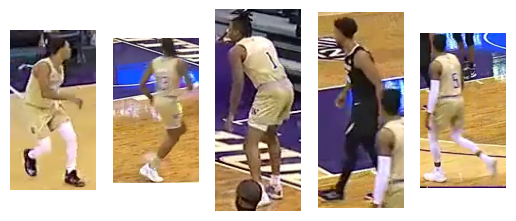

In [15]:
fig = plt.figure()
for index in range(5):
    player = players_rgb_dataset[0]['annotations'][index]['player']    
    ax = plt.subplot(1, 5, index + 1)
    ax.imshow(player)
    ax.axis('off')
plt.imshow(player)
pass

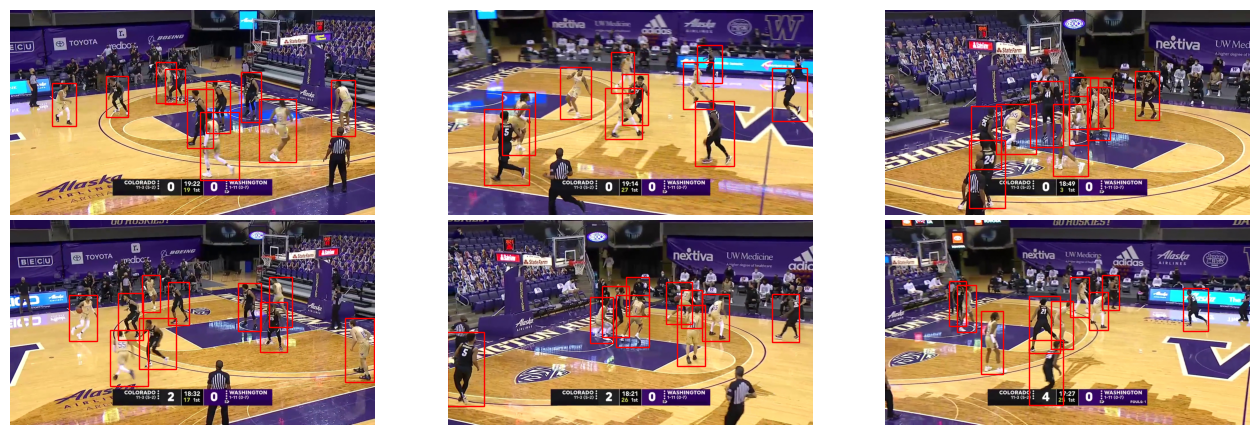

In [16]:
def plot_players(dataset):
    plt.figure(figsize=(16, 10))

    row = 1
    
    for index, data in enumerate(dataset[:6]):
        if index % 3 == 0:
            row += 1

        image = data['image']
        annotations = data['annotations']
    
        ax = plt.subplot(row, 3, index + 1)
    
        for annotation in annotations:
            x, y, w, h = annotation['box']
            patch = patches.Rectangle(
                (x, y), w, h,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(patch)
            
        ax.axis('off')
        ax.imshow(image)
        
    
    plt.show()

plot_players(players_rgb_dataset)

In [17]:
def classify(X, y):
    def calculate_accuracy(ground_truth, predictions):
        correct_preds = 0
        total_preds = 0

        for gt, pred in zip(ground_truth, predictions):
            correct_preds += (gt == pred).sum().item()
            total_preds += len(pred)

        accuracy = correct_preds / total_preds

        return accuracy

    simple_imputer = sklearn.impute.SimpleImputer()
    simple_imputer.fit(X)
    X = simple_imputer.transform(X)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=False,
    )

    y_test = y_test.reshape(-1, 10)

    k_neighbours = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)
    k_neighbours.fit(X_train, y_train)

    y_pred = k_neighbours.predict(X_test)
    y_pred = y_pred.reshape(-1, 10)

    k_neighbors_accuracy = calculate_accuracy(y_test, y_pred)

    k_means = sklearn.cluster.KMeans(n_clusters=2)
    k_means.fit(X_train, y_train)
    y_pred = k_means.predict(X_test)
    y_pred = y_pred.reshape(-1, 10)
    k_means_accuracy = calculate_accuracy(y_test, y_pred)

    rfc = sklearn.ensemble.RandomForestClassifier()

    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_pred = y_pred.reshape(-1, 10)
    rfc_accuracy = calculate_accuracy(y_test, y_pred)

    return {
        'k_neighbors': k_neighbors_accuracy,
        'k_means': k_means_accuracy,
        'rfc': rfc_accuracy,
    }

In [18]:
def get_features_for_mean_colorspace(dataset):
    X = np.array([])
    y = np.array([])

    for index in range(len(dataset)):
        players = [annotation['player'] for annotation in dataset[index]['annotations']]

        team_ids = np.array([
            annotation['team']
            for annotation in dataset[index]['annotations']
        ], dtype=np.int8)

        image_features= []

        for player in players:
            feature = np.mean(player.reshape(-1, 3), axis=0)
            image_features.append(feature)

        if len(X) > 0:
            X = np.concatenate([X, image_features], axis=0)
            y = np.concatenate([y, team_ids], axis=0)
        else:
            X = image_features
            y = team_ids

    return X, y

X, y = get_features_for_mean_colorspace(players_rgb_dataset)

mean_rgb_result = classify(X, y)

/home/stepan/Private/player-class/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stepan/Private/player-class/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [19]:
X, y = mean_rgb_features = get_features_for_mean_colorspace(players_hsv_dataset)

mean_hsv_result = classify(X, y)

/home/stepan/Private/player-class/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stepan/Private/player-class/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


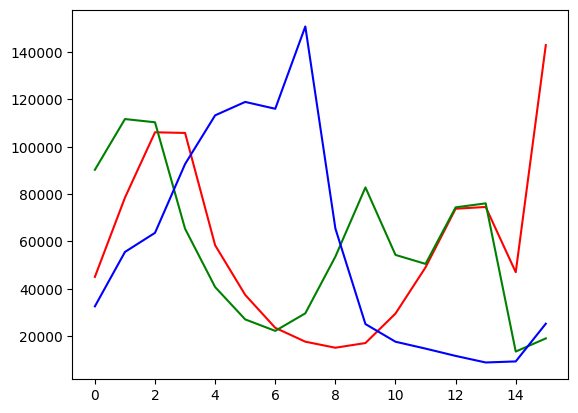

In [20]:
for i, color in enumerate(['r', 'g', 'b']):
    hist = cv2.calcHist([players_rgb_dataset[0]['image']], [i], None, [16], [0, 256])
    plt.plot(hist, color=color)


In [21]:
def get_features_for_hist_colorspace(dataset):
    X = np.array([])
    y = np.array([])

    for index in range(len(dataset)):
        players = [annotation['player'] for annotation in dataset[index]['annotations']]

        team_ids = np.array([
            annotation['team']
            for annotation in dataset[index]['annotations']
        ], dtype=np.int8)

        image_features = []

        for player in players:
            h, w, c = player.shape
            image_feature = np.concatenate([
                cv2.calcHist([player], [index], None, [32], [0, 256]) / (w * h)
                for index in range(c)
            ], axis=1)
            image_features.append(image_feature.reshape(-1))

        if len(X) > 0:
            X = np.concatenate([X, image_features], axis=0)
            y = np.concatenate([y, team_ids], axis=0)
        else:
            X = image_features
            y = team_ids

    return X, y

X, y = get_features_for_hist_colorspace(players_rgb_dataset)

hist_rgb_result = classify(X, y)

/tmp/ipykernel_22557/2688596157.py:18: RuntimeWarning: invalid value encountered in divide
  cv2.calcHist([player], [index], None, [32], [0, 256]) / (w * h)


In [22]:
X, y = get_features_for_hist_colorspace(players_hsv_dataset)

hist_hsv_result = classify(X, y)

/tmp/ipykernel_22557/2688596157.py:18: RuntimeWarning: invalid value encountered in divide
  cv2.calcHist([player], [index], None, [32], [0, 256]) / (w * h)


In [24]:
{
    'mean_rgb': mean_rgb_result,
    'mean_hsv': mean_hsv_result,
    'hist_rgb': hist_rgb_result,
    'hist_hsv': hist_hsv_result,
}

{'mean_rgb': {'k_neighbors': 0.63, 'k_means': 0.69, 'rfc': 0.71},
 'mean_hsv': {'k_neighbors': 0.665, 'k_means': 0.38, 'rfc': 0.705},
 'hist_rgb': {'k_neighbors': 0.755, 'k_means': 0.565, 'rfc': 0.825},
 'hist_hsv': {'k_neighbors': 0.675, 'k_means': 0.42, 'rfc': 0.845}}